In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt


Step 1 - Load Sample 151507

In [3]:
adata = sc.read_visium(
    r"C:\Users\megha\Desktop\project\data\151507"
)

adata.var_names_make_unique()
adata.obs["sample_id"] = "151507"

adata


C:\Users\megha\AppData\Local\Temp\ipykernel_27408\199574153.py:1: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Step 2 - Quality Control (QC)

Calculate QC metrics (genes, counts, mito%)

In [4]:
# Mark mitochondrial genes (human: "MT-")
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Compute QC metrics per spot
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Quick check
adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].describe()


,total_counts,n_genes_by_counts,pct_counts_mt
count,4226.000000,4226.000000,4226.000000
mean,2592.443848,1410.170374,18.071293
std,1198.876587,535.740370,3.931414
min,63.000000,55.000000,6.338583
25%,1705.000000,1016.250000,15.354380
50%,2463.500000,1384.000000,17.960207
75%,3313.750000,1764.750000,20.829882
max,9011.000000,3619.000000,35.873016


Visualize distributions (to choose thresholds)

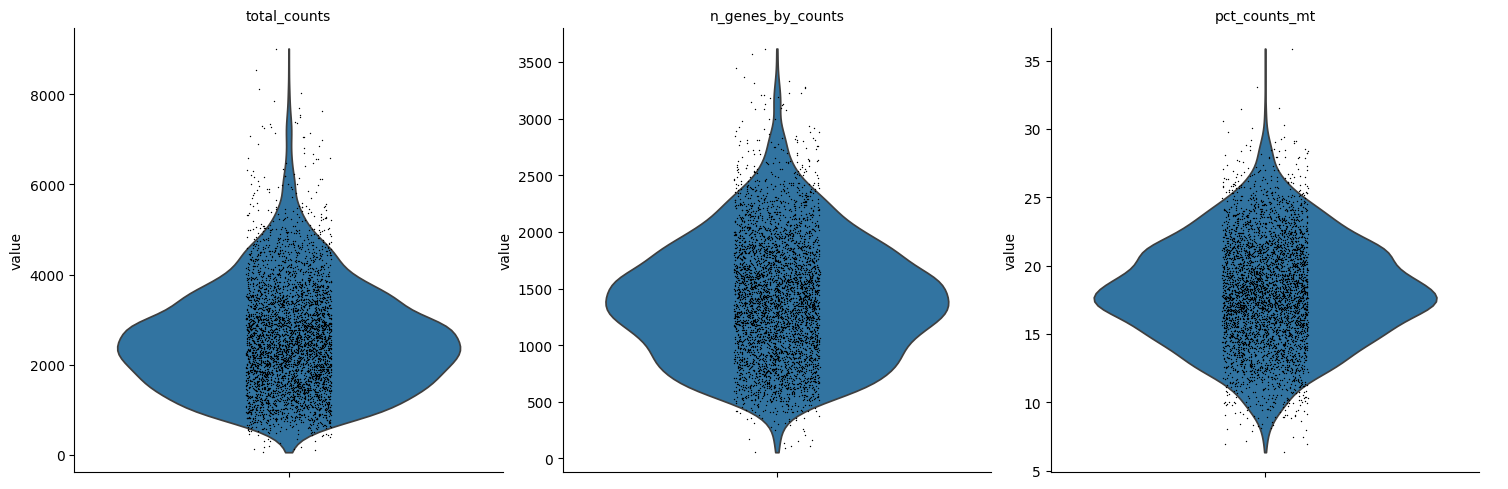

In [5]:
sc.pl.violin(
    adata,
    ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    multi_panel=True
)


(more detailed)

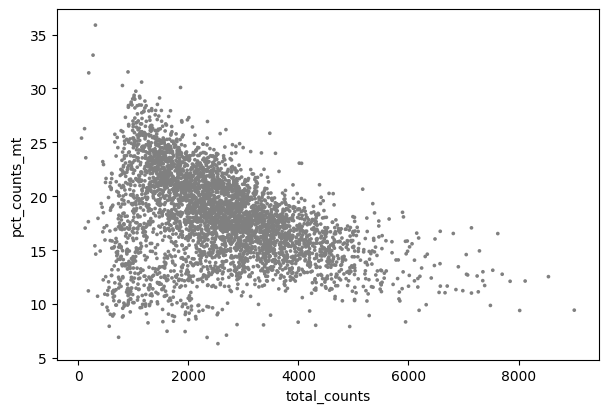

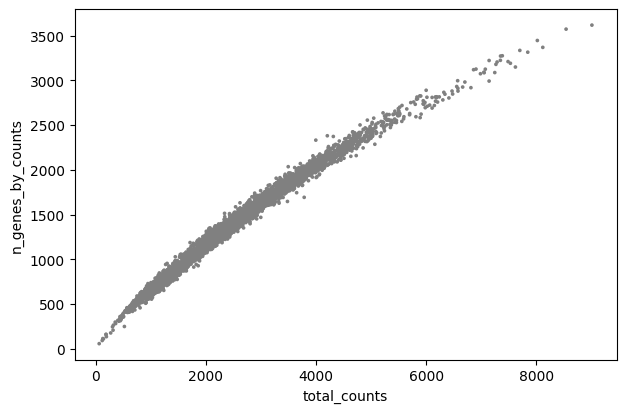

In [6]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")


Filter bad spots (start with reasonable defaults)

Remove spots with <200 genes

Remove spots with >25% mito

Remove top 1% total counts

In [7]:
# Save original spot count
n_before = adata.n_obs

# Define upper cutoff for extreme high counts (top 1%)
upper_counts = adata.obs["total_counts"].quantile(0.99)

# Apply filters
adata_qc = adata[
    (adata.obs["n_genes_by_counts"] >= 200) &
    (adata.obs["pct_counts_mt"] <= 25) &
    (adata.obs["total_counts"] <= upper_counts)
].copy()

n_after = adata_qc.n_obs

print(f"Spots before QC: {n_before}")
print(f"Spots after QC : {n_after}")
print(f"Removed        : {n_before - n_after}")
print(f"Percent removed: {(n_before-n_after)/n_before:.2%}")


Spots before QC: 4226
Spots after QC : 4013
Removed        : 213
Percent removed: 5.04%


Confirm QC effect visually (spatial)

C:\Users\megha\AppData\Local\Temp\ipykernel_27408\2083778884.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color="pct_counts_mt", spot_size=1.5)


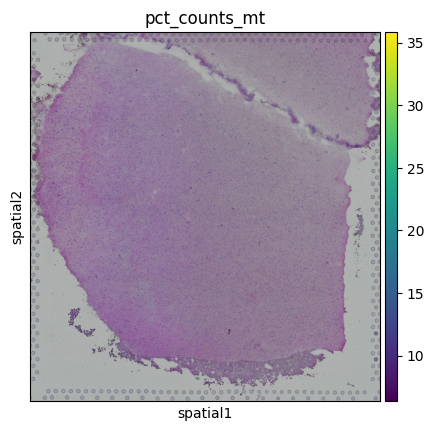

C:\Users\megha\AppData\Local\Temp\ipykernel_27408\2083778884.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color="n_genes_by_counts", spot_size=1.5)


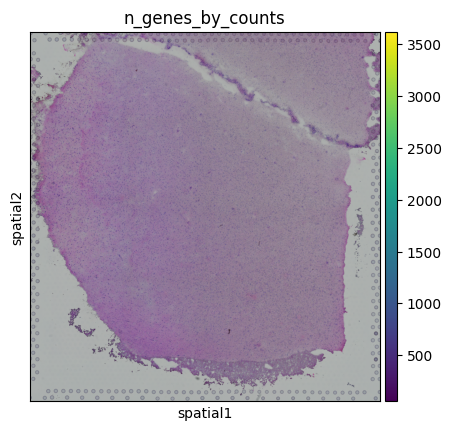

C:\Users\megha\AppData\Local\Temp\ipykernel_27408\2083778884.py:6: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_qc, color="sample_id", spot_size=1.5)


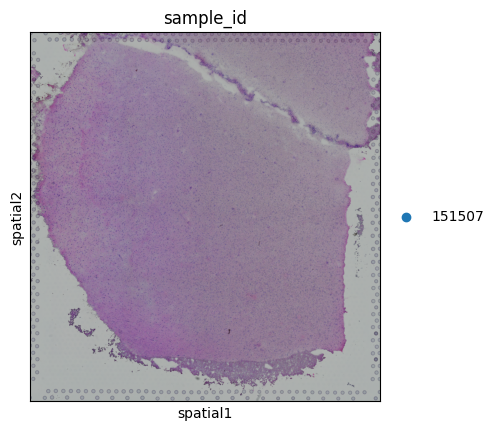

In [8]:
# Visualize QC metrics spatially (are bad spots localized?)
sc.pl.spatial(adata, color="pct_counts_mt", spot_size=1.5)
sc.pl.spatial(adata, color="n_genes_by_counts", spot_size=1.5)

# Visualize where filtered spots remain
sc.pl.spatial(adata_qc, color="sample_id", spot_size=1.5)


Save your QC’d object

In [9]:
adata_qc.write("../results/processed/151507_qc.h5ad")


STEP 3 — Normalization + log transform

In [11]:
# Normalize counts per spot (library size normalization)
sc.pp.normalize_total(adata_qc, target_sum=1e4)

# Log transform
sc.pp.log1p(adata_qc)

# Save raw (so we can still use original counts for markers later)
adata_qc.raw = adata_qc

adata_qc



AnnData object with n_obs × n_vars = 4013 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'sample_id_colors', 'log1p'
    obsm: 'spatial'

STEP 4 — Highly Variable Gene (HVG) Selection

In [12]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata_qc,
    flavor="seurat",
    n_top_genes=3000
)

# How many selected?
print("Number of HVGs:", adata_qc.var['highly_variable'].sum())


Number of HVGs: 3000


In [13]:
adata_hvg = adata_qc[:, adata_qc.var['highly_variable']].copy()

adata_hvg


AnnData object with n_obs × n_vars = 4013 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'sample_id_colors', 'log1p', 'hvg'
    obsm: 'spatial'

STEP 5 — PCA (Real Dimensionality Reduction)

c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


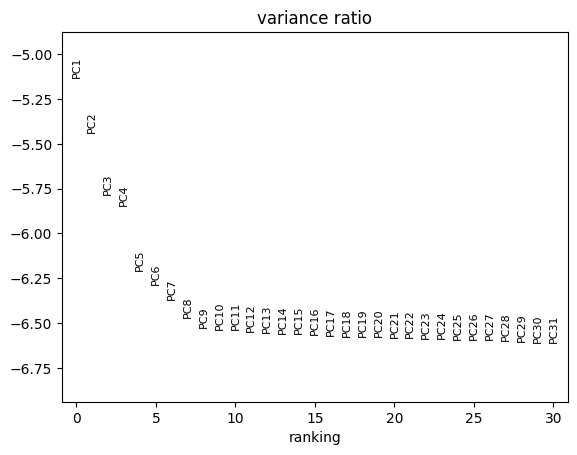

In [14]:
# Scale data (required before PCA)
sc.pp.scale(adata_hvg, max_value=10)

# Run PCA
sc.tl.pca(adata_hvg, svd_solver='arpack')

# Visualize explained variance
sc.pl.pca_variance_ratio(adata_hvg, log=True)


In [18]:
adata_hvg.obs["PC1"] = adata_hvg.obsm["X_pca"][:, 0]
adata_hvg.obs["PC2"] = adata_hvg.obsm["X_pca"][:, 1]


C:\Users\megha\AppData\Local\Temp\ipykernel_27408\2565235918.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_hvg, color="PC1", spot_size=1.5)


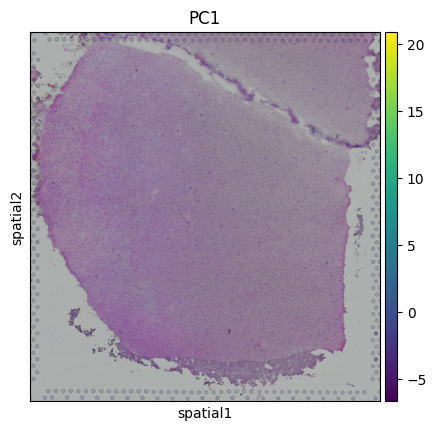

In [19]:
sc.pl.spatial(adata_hvg, color="PC1", spot_size=1.5)


In [20]:
# Get genes driving PC1
pc1_loadings = pd.Series(
    adata_hvg.varm["PCs"][:, 0],
    index=adata_hvg.var_names
).sort_values(ascending=False)

pc1_loadings.head(20)


SCGB2A2     0.128033
PLP1        0.127614
MOBP        0.126943
TF          0.123779
SPP1        0.110270
CNP         0.107861
PPP1R14A    0.107665
SCGB1D2     0.105622
ERMN        0.104555
MAG         0.103289
CLDN11      0.102205
MBP         0.101651
KRT18       0.100266
KRT8        0.099706
MOG         0.098843
S100A11     0.097486
MYRF        0.095595
MUC1        0.094676
CRYAB       0.094464
TMEM144     0.093979
dtype: float64

Step – 5 - Expression-only clustering

Build graph in PCA space

In [28]:
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=20)


Leiden clustering

In [29]:
sc.tl.leiden(adata_hvg, resolution=0.5)


Visualize spatially (just for interpretation)

In [30]:
adata_hvg.obs["leiden"].value_counts()


leiden
0    1650
1    1322
2     716
3     325
Name: count, dtype: int64

C:\Users\megha\AppData\Local\Temp\ipykernel_27408\1130411375.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


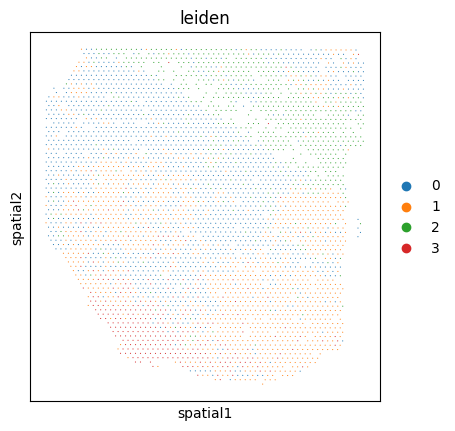

In [31]:
sc.pl.spatial(
    adata_hvg,
    color="leiden",
    img_key=None,        # remove histology image
    spot_size=30         # make spots large
)


Save the processed object

In [32]:
adata_hvg.write_h5ad("../results/151507_processed.h5ad")
